<a href="https://colab.research.google.com/github/hksantosh/eip/blob/master/Assignment%205/PersonAttributes_VGG16_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
d=[]
while(1):
  d.append('1')

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/EIP4/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [2]:
%tensorflow_version 2.x

import os, cv2, json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import backend
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.layers import Dense, SeparableConv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

TensorFlow 2.x selected.


In [3]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [4]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        
        images = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])        
        if self.augmentation is not None:
            images = self.augmentation.flow(images, shuffle=False).next()
        
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        
        return images, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [6]:
train_df, val_df = train_test_split(one_hot_df, test_size=0.15)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [7]:
train_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
9526,resized/9527.jpg,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
1981,resized/1982.jpg,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
9778,resized/9779.jpg,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0
3224,resized/3225.jpg,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0
1134,resized/1135.jpg,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0


In [8]:
val_df.head()

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
5057,resized/5058.jpg,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
7763,resized/7764.jpg,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0
12448,resized/12450.jpg,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1
7942,resized/7943.jpg,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
6471,resized/6472.jpg,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [10]:
# create train and validation data generators
#train_gen = PersonDataGenerator(train_df, batch_size=64)
train_gen = PersonDataGenerator(
    train_df, 
    batch_size=32, 
    augmentation=ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        preprocessing_function =
                    get_random_eraser(v_l=0, v_h=255, s_l=0.02, s_h=0.05, 
                                                 r_1=0.75, r_2=1/0.75, pixel_level=True)
    )
)

#valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False)
valid_gen = PersonDataGenerator(
    val_df, 
    batch_size=32, 
    augmentation=ImageDataGenerator(
        rescale=1./255
    )
)

len(train_gen), len(valid_gen)

(360, 63)

In [11]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [12]:
images.shape, targets.get('gender_output').shape, targets.get('age_output').shape

((32, 224, 224, 3), (32, 2), (32, 5))

In [0]:
backbone = VGG16(
    weights=None, 
    include_top=False, 
    input_tensor=Input(shape=(224, 224, 3))
)

neck = backbone.output
neck = Flatten(name="flatten")(neck)
neck = Dense(128, activation="relu")(neck)


def build_tower(in_layer):
    neck = Dense(128, activation="relu")(in_layer)
    neck = BatchNormalization(momentum=0.3)(neck)
    neck = Dropout(0.06)(neck)
    #neck = BatchNormalization(momentum=0.2)(neck)
    #neck = Dropout(0.03)(neck)
    #neck = Dense(256, activation="relu")(neck)
    return neck


def build_head(name, in_layer):
    return Dense(
        num_units[name], activation="softmax", name=f"{name}_output"
    )(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))


model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

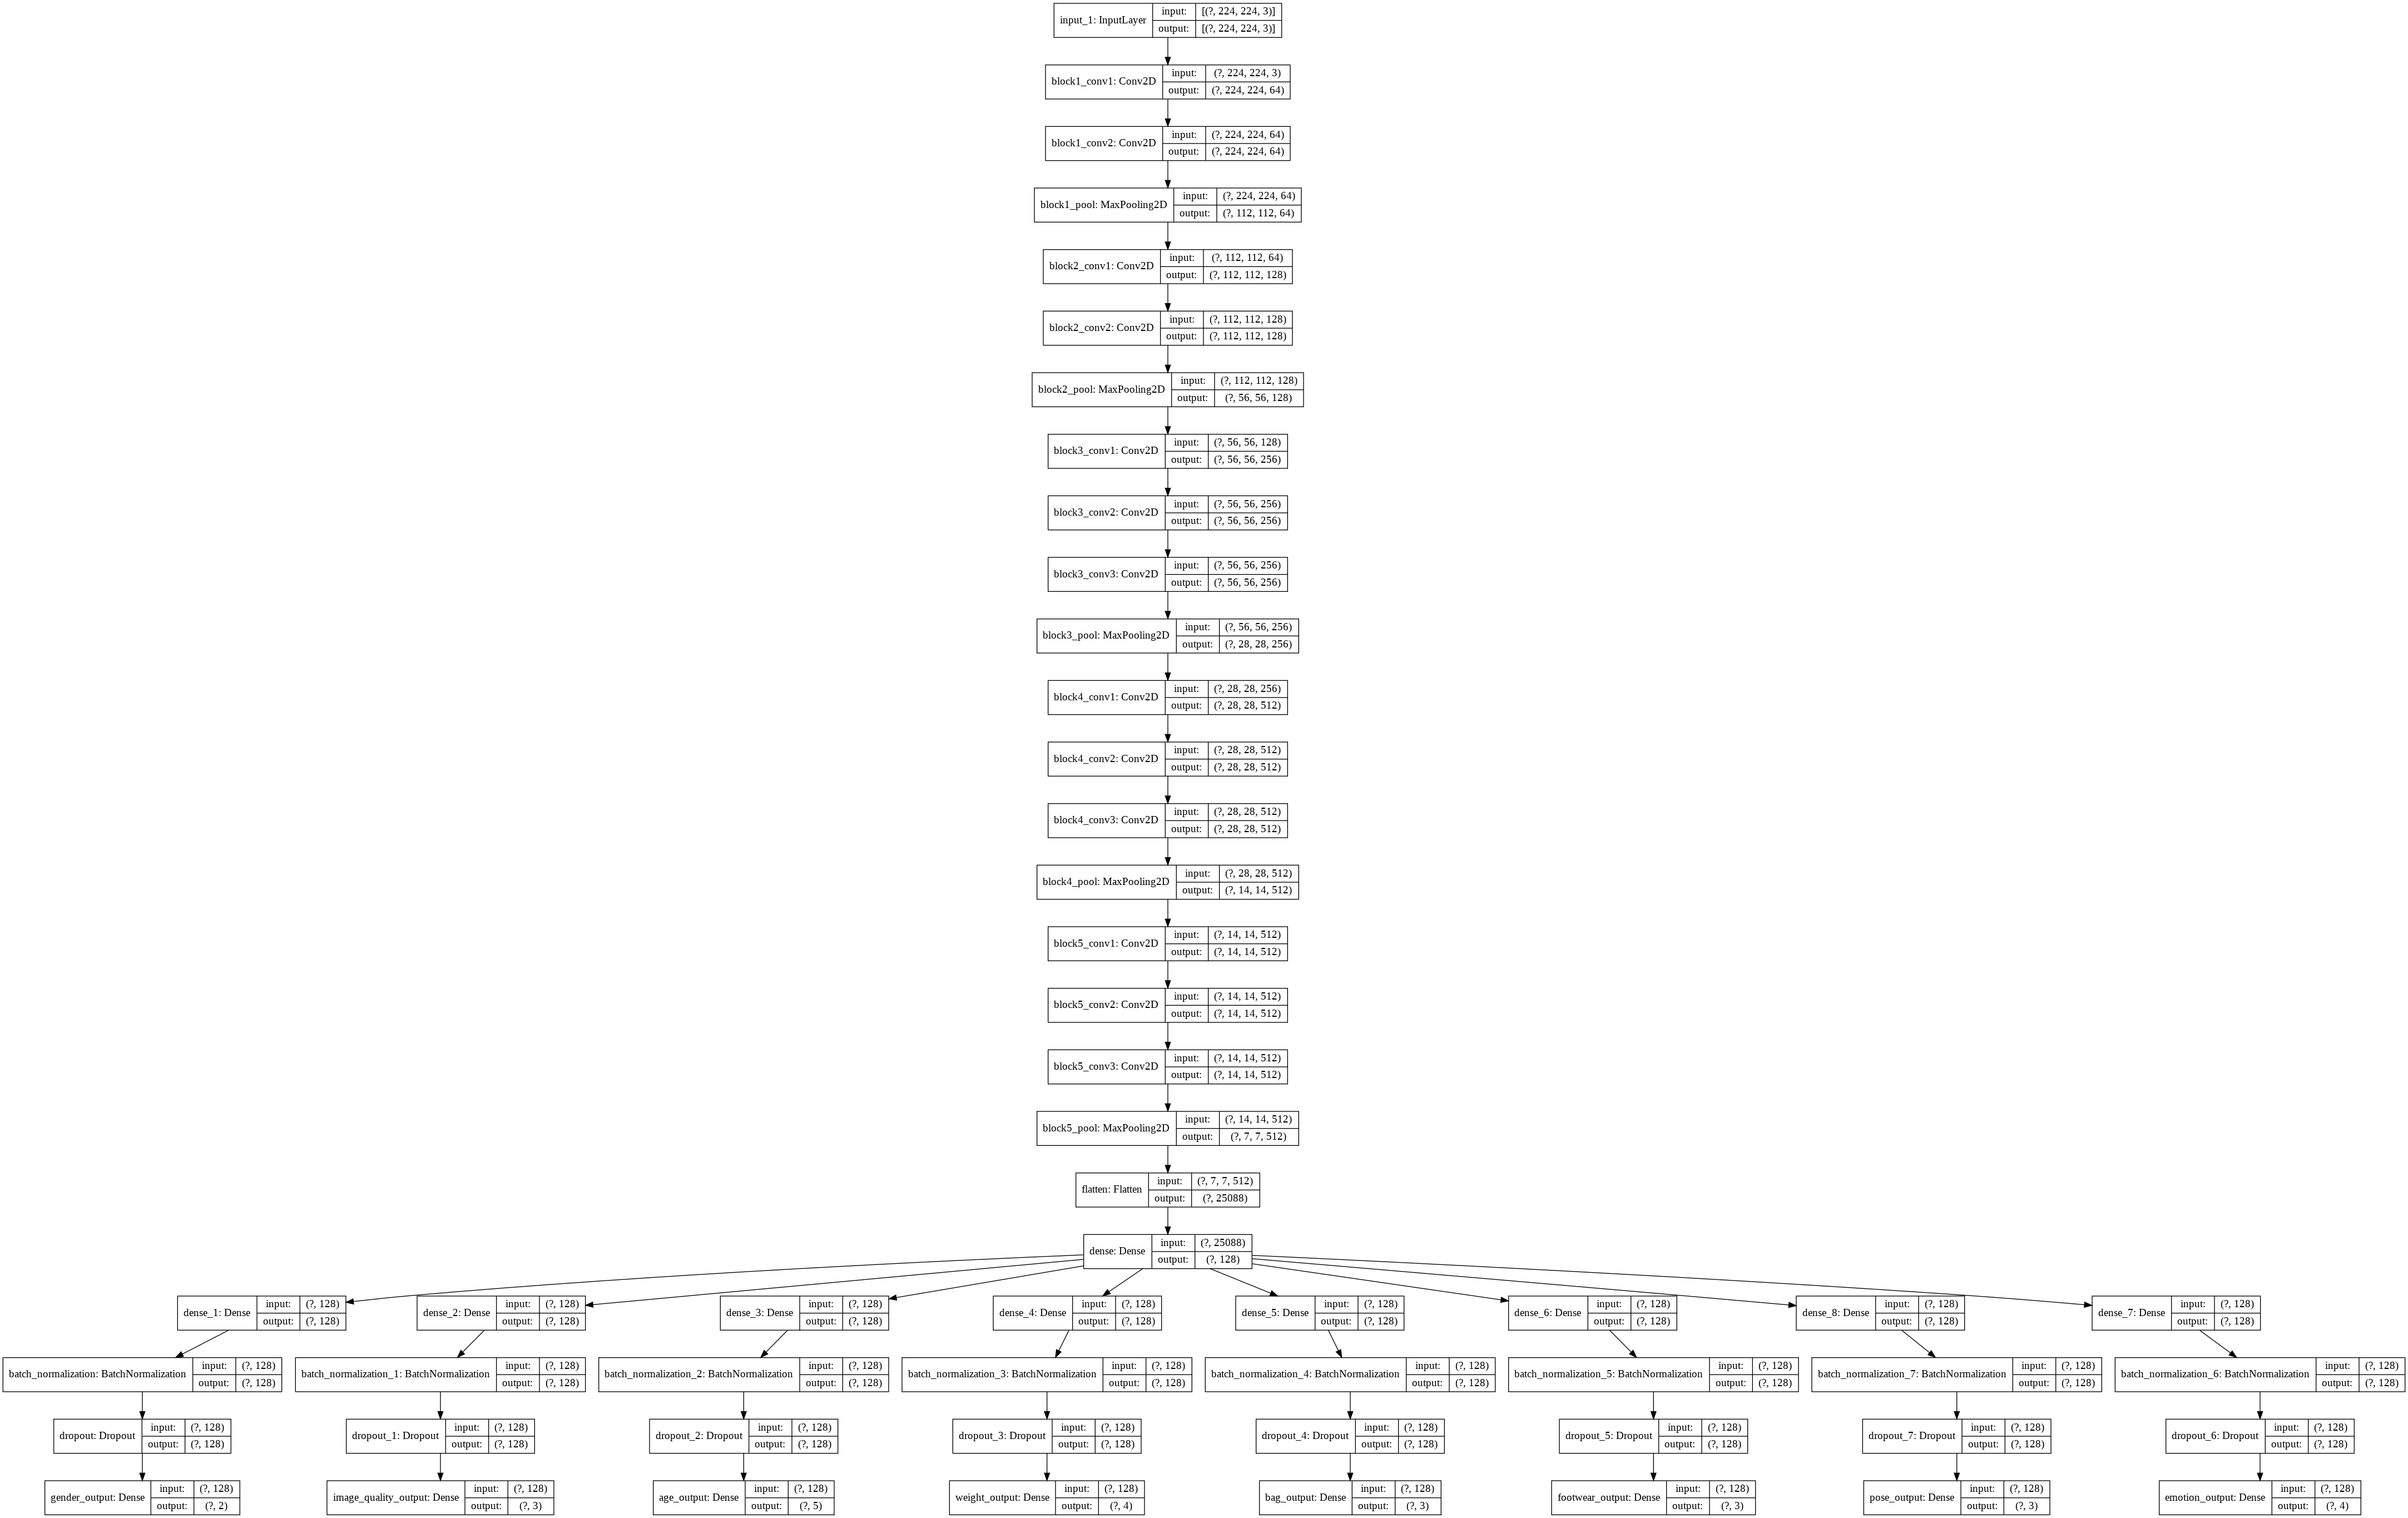

In [14]:
plot_model(model, show_shapes=True)

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 160:
        lr *= 0.5e-3
    elif epoch > 120:
        lr *= 1e-3
    elif epoch > 80:
        lr *= 1e-2
    elif epoch > 40:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# monitor the learning rate
class LearningRateMonitor(Callback):
  # start of training
  def on_train_begin(self, logs={}):
    self.lrates = list()

  # end of each training epoch
  def on_epoch_end(self, epoch, logs={}):
    # get and store the learning rate
    optimizer = self.model.optimizer
    lrate = float(backend.get_value(self.model.optimizer.lr))
    print('Learning rate used for the completed epoch:', lrate)
    self.lrates.append(lrate)

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath='/content/gdrive/My Drive/EIP4/models/PersonAttributes_VGG16_model_z.h5',
                             monitor='val_loss',
                             verbose=2,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)
lrm = LearningRateMonitor()

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0,
                               patience=5, min_lr=0.1e-7)

#callbacks = [checkpoint, lr_reducer, lr_scheduler]
callbacks = [checkpoint, lr_reducer, lrm]

In [0]:
losses = {
 	"gender_output": "binary_crossentropy",
 	"image_quality_output": "categorical_crossentropy",
 	"age_output": "categorical_crossentropy",
 	"weight_output": "categorical_crossentropy",
 	"bag_output": "categorical_crossentropy",
 	"footwear_output": "categorical_crossentropy",
 	"pose_output": "categorical_crossentropy",
 	"emotion_output": "categorical_crossentropy"
}

loss_weights = {
    "gender_output": 2.0, "image_quality_output": 1.0, "age_output": 0.25, "weight_output": 0.5,
    "bag_output": 1.0,  "footwear_output": 1.0,  "pose_output": 1.5,  "emotion_output": 0.75
    }

opt = SGD(lr=0.01, momentum=0.8)
#opt = SGD(lr=0.01, momentum=0.9, decay=0.01)
model.compile(
    optimizer=opt,
    loss=losses,
    loss_weights=loss_weights,
    metrics=["accuracy"]
)

In [0]:
model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
#    use_multiprocessing=True,
    workers=4, 
    epochs=200,
    callbacks=callbacks,
    verbose=2
)

Instructions for updating:
Please use Model.fit, which supports generators.
  {'gender_output': '...', 'image_quality_output': '...', 'age_output': '...', 'weight_output': '...', 'bag_output': '...', 'pose_output': '...', 'footwear_output': '...', 'emotion_output': '...'}
    to  
  ['...', '...', '...', '...', '...', '...', '...', '...']
  {'gender_output': '...', 'image_quality_output': '...', 'age_output': '...', 'weight_output': '...', 'bag_output': '...', 'pose_output': '...', 'footwear_output': '...', 'emotion_output': '...'}
    to  
  ['...', '...', '...', '...', '...', '...', '...', '...']
Train for 360 steps, validate for 63 steps
Epoch 1/200

Epoch 00001: val_loss improved from inf to 14.29558, saving model to /content/gdrive/My Drive/EIP4/models/PersonAttributes_VGG16_model_z.h5
Learning rate used for the completed epoch: 0.009999999776482582
360/360 - 102s - loss: 7.1836 - gender_output_loss: 0.6762 - image_quality_output_loss: 0.9843 - age_output_loss: 1.4668 - weight_out